# Application 1: Showcase 

In [1]:
from ssm4epi.models.regional_growth_factor import (
    key,
    n_iterations,
    N_mle,
    N_meis,
    N_posterior,
    percentiles_of_interest,
    make_aux,
    dates_full,
    cases_full,
    n_ij,
    n_tot,
    account_for_nans,
    growth_factor_model,
)

import jax.numpy as jnp
import jax
import jax.random as jrn

from isssm.importance_sampling import prediction
from isssm.laplace_approximation import laplace_approximation as LA
from isssm.modified_efficient_importance_sampling import (
    modified_efficient_importance_sampling as MEIS,
)

from pyprojroot.here import here

jax.config.update("jax_enable_x64", True)
from isssm.estimation import initial_theta
import pickle
import matplotlib.pyplot as plt

In [2]:
from datetime import date
import pandas as pd

initial_date = "2020-04-18"
np1 = 10
(dates_index,) = jnp.where(dates_full == initial_date)[0]
dates = dates_full[dates_index : dates_index + np1]
aux = make_aux(initial_date, cases_full, n_ij, n_tot, np1)

y = aux[0][1:]
y_nan = y.at[-1].set(jnp.nan)
missing_inds = jnp.isnan(y_nan)
theta_manual = jnp.array(
    [5.950e00, -2.063e00, -5.355e00, -4.511e-01, -5.711e-01, 7.932e-01]
)
_, y_miss = account_for_nans(
    growth_factor_model(theta_manual, aux), y_nan, missing_inds
)
_model_miss = lambda theta, aux: account_for_nans(
    growth_factor_model(theta, aux), y_nan, missing_inds
)[0]

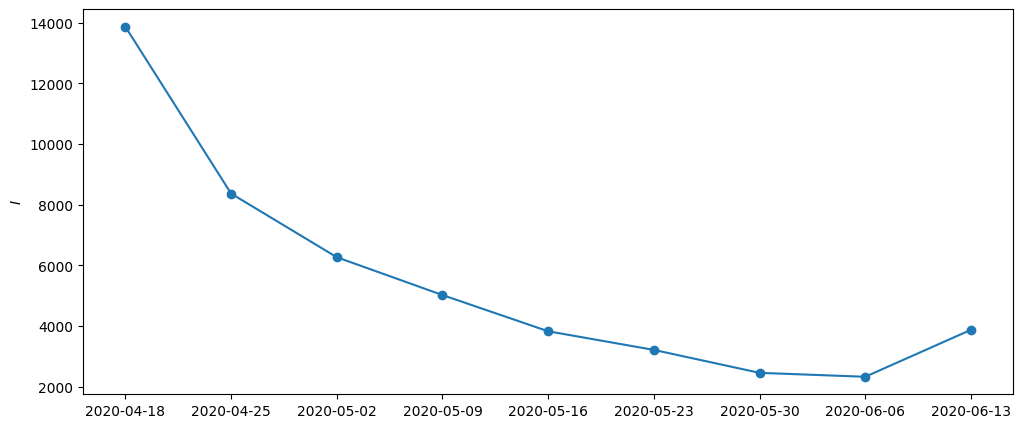

In [3]:
plt.figure(figsize=(12, 5))
plt.ylabel("$I$")
plt.plot(dates, y_nan.sum(axis=-1))
plt.scatter(dates, y_nan.sum(axis=-1))
plt.show()

In [4]:
theta0_result = initial_theta(
    y_miss,
    _model_miss,
    theta_manual,
    aux,
    n_iter_la=n_iterations,
    options={"maxiter": 10},
)
theta0 = theta0_result.x
fitted_model = _model_miss(theta0, aux)

In [5]:
proposal_la, info_la = LA(y_miss, fitted_model, n_iterations)
# key, subkey = jrn.split(key)
# proposal_meis, info_meis = MEIS(
#    y_miss, fitted_model, proposal_la.z, proposal_la.Omega, n_iterations, N_meis, subkey
# )


def f_pred(x, s, y):
    y_county = y[-1]
    y_tot = jnp.minimum(y_county, n_tot).sum()[None]
    growth_factors = s.reshape(-1)
    return jnp.concatenate([y_tot, y_county, growth_factors])


key, subkey = jrn.split(key)
preds = prediction(
    f_pred,
    y_miss,
    proposal_la,
    fitted_model,
    1000,
    subkey,
    percentiles_of_interest,
    growth_factor_model(theta0, aux),
)

result = (theta0, proposal_la, preds, dates, y)

with open(here() / "data/results/4_local_outbreak_model/results.pickle", "wb") as f:
    pickle.dump(result, f)

In [6]:
with open(here() / "data/results/4_local_outbreak_model/results.pickle", "rb") as f:
    result = pickle.load(f)

In [7]:
theta0, proposal, preds, dates, y = result

C: 1.46
Sigma spatial: 0.07


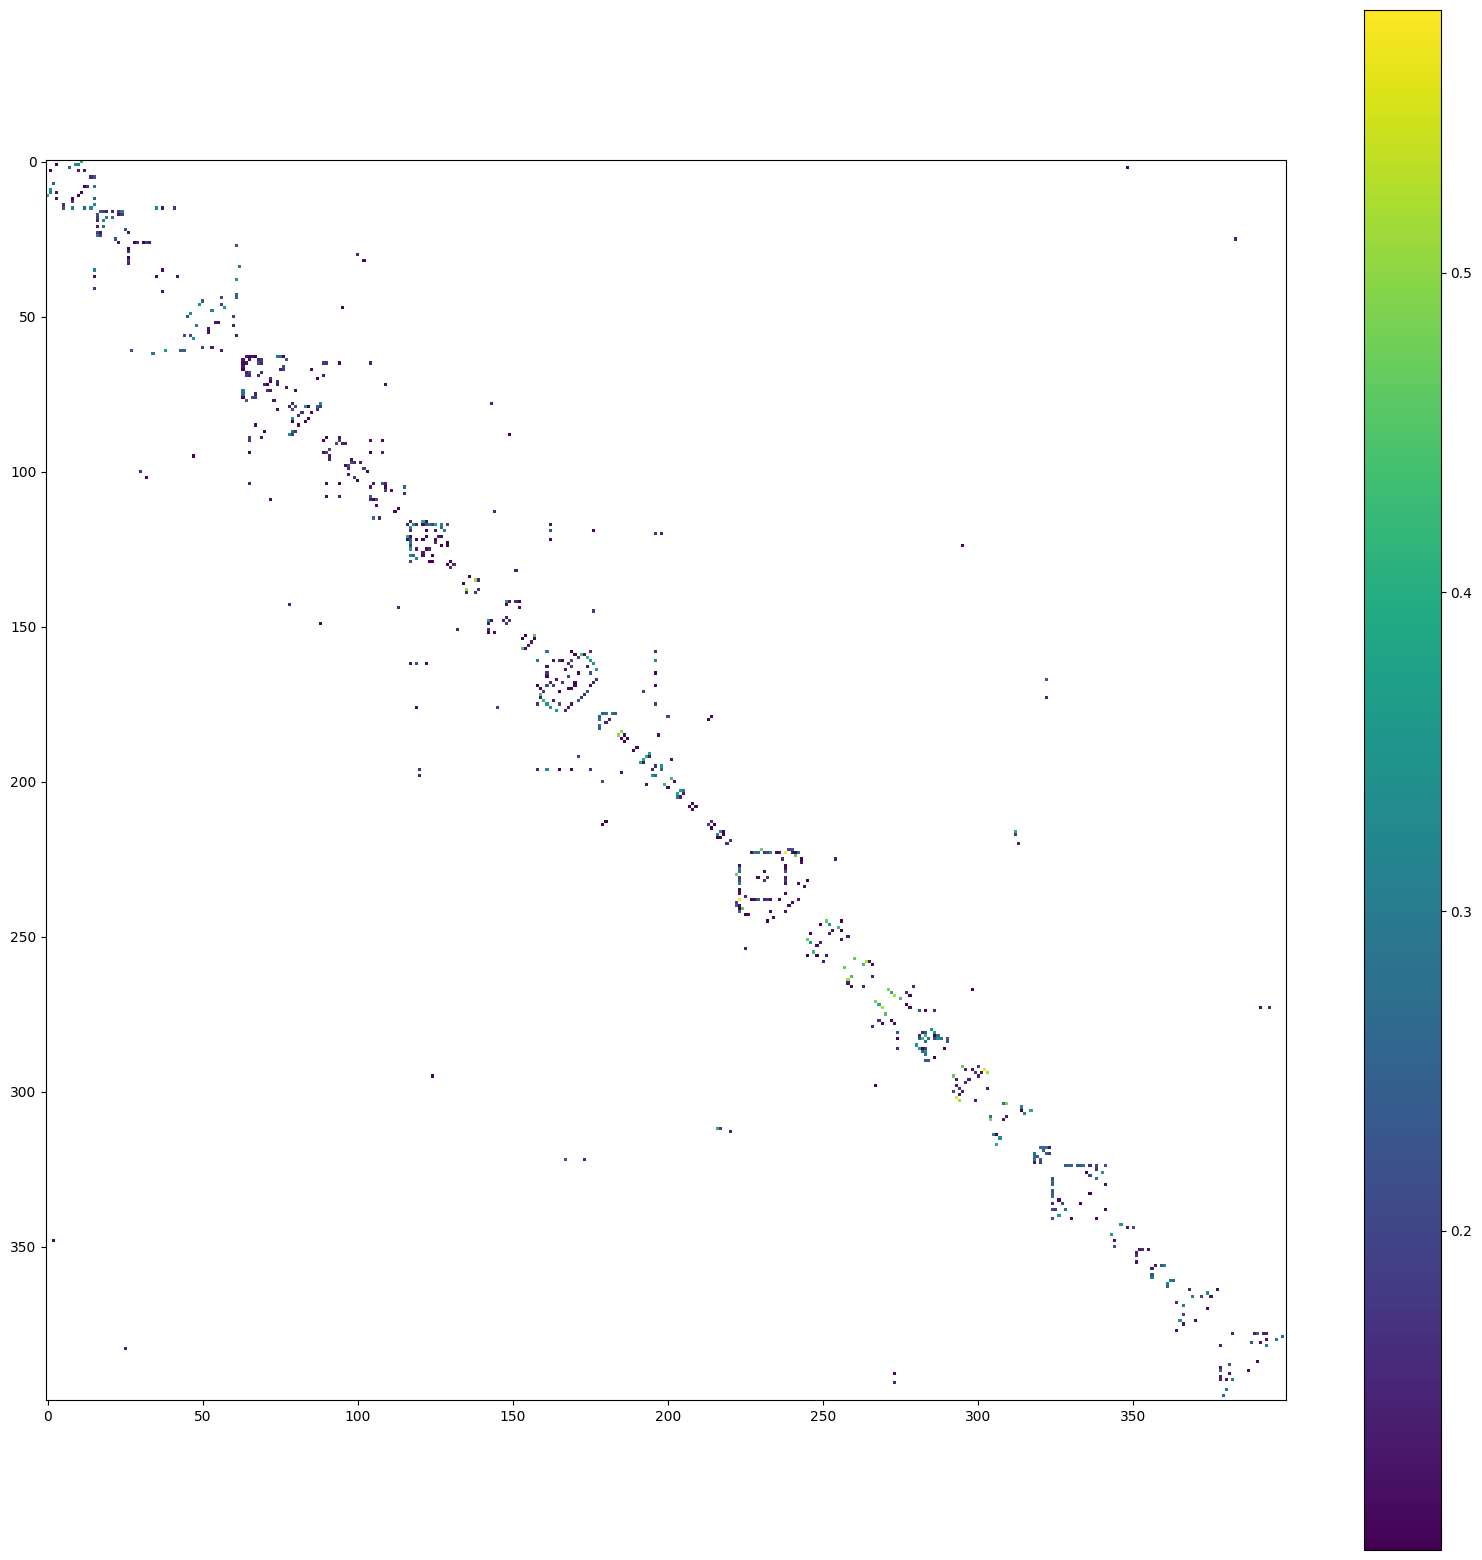

In [40]:
from ssm4epi.models.regional_growth_factor import _P
import jax.scipy as jsp

logit_alpha, log_s2_r, log_s2_spat, logit_q, log_Cm1, log_r = theta0


def cov_to_corr(cov):
    # Extract standard deviations from the diagonal
    stddev = jnp.sqrt(jnp.diag(cov))
    # Compute the outer product of stddev for normalization
    denom = jnp.outer(stddev, stddev)
    # Compute the correlation matrix
    corr = cov / denom
    return corr


C = jnp.exp(log_Cm1) + 1
s2_spat = jnp.exp(log_s2_spat)
print(f"C: {C:.2f}")
print(f"Sigma spatial: {jnp.sqrt(s2_spat):.2f}")
q = jsp.special.expit(logit_q)
P = _P(C, q, n_ij, n_tot)
P_for_plot = cov_to_corr(s2_spat * P.T @ P) - jnp.eye(400)
threshold = 0.1
P_for_plot = jnp.where(P_for_plot < threshold, jnp.nan, P_for_plot)
plt.figure(figsize=(20, 20))
plt.imshow(P_for_plot)
plt.colorbar()
plt.show()

In [8]:
import pandas as pd

df = pd.DataFrame(
    {
        "variable": [
            "y_total",
            *[f"y_total_{c}" for c in range(1, 401)],
            *[f"log_rho_{c}_{t}" for t in range(1, 11) for c in range(1, 401)],
        ],
        "c": [0, *range(1, 401), *[c for t in range(1, 11) for c in range(1, 401)]],
        "t": [
            10,
            *jnp.repeat(10, 400),
            *[t for t in range(1, 11) for c in range(1, 401)],
        ],
        "mean": preds[0],
        "sd": preds[1],
        **{
            f"{p * 100:.1f} %": preds[2][i, :]
            for i, p in enumerate(percentiles_of_interest)
        },
    }
)

df["date"] = [dates[t - 1] for t in df["t"]]
df.to_csv(here("data/results/4_local_outbreak_model/showcase.csv"), index=False)

/Users/stefan/workspace/work/phd/thesis/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


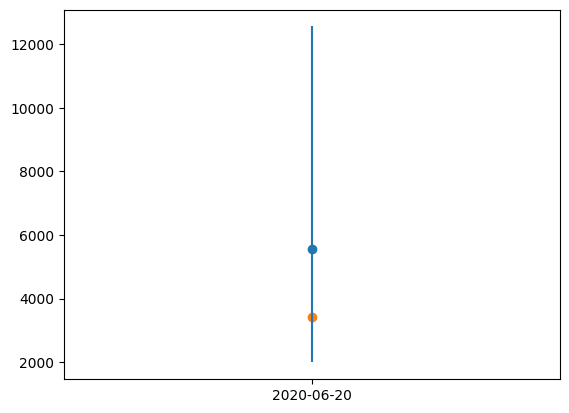

In [17]:
df_total = df[df["variable"] == "y_total"]

plt.errorbar(
    df_total["date"],
    df_total["50.0 %"],
    yerr=[
        df_total["50.0 %"] - df_total["2.5 %"],
        df_total["97.5 %"] - df_total["50.0 %"],
    ],
)
plt.scatter(df_total["date"], df_total["50.0 %"])
plt.scatter(df_total["date"], y[-1].sum())

In [13]:
df_total

,variable,c,t,mean,sd,1.0 %,2.5 %,5.0 %,10.0 %,15.0 %,...,65.0 %,70.0 %,75.0 %,80.0 %,85.0 %,90.0 %,95.0 %,97.5 %,99.0 %,date
0,y_total,0,10,4989.174835,3004.810171,1991.911875,1993.291547,1995.591,2000.189905,2004.788811,...,6042.965328,6043.362566,6043.759803,6351.499019,7269.735329,8488.0,10497.861726,12558.585576,14988.766111,2020-06-20
